# Model template using multiple polygons
This is an exercise to test the computing time for fitting and predicting spatial models using an assortment of different polygons.

This can work as a general template for other models and data pipelines.

In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()

#import traversals.strategies as st
#from os import walk
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np
import pymc3 as pm

## Use the ggplot style
plt.style.use('ggplot')

/opt/conda/envs/biospytial/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from external_plugins.spystats.spystats import utilities as ut

In [3]:
train_path = '/outputs/presence_only_models/data/burseras'
train_dataset = ut.loadDataset(train_path)

#train_path = '/outputs/presence_only_models/data/root'
#train_dataset = ut.loadDataset(train_path)
## Predictors
pred_path = '/outputs/presence_only_models/predictors/datasetp2'
pred_dataset = ut.loadDataset(pred_path)
### PATCH, the thing is taking backwards the order of the lists of files, because of the name
#pred_dataset.reverse()
prediction_dataset_dic= map(lambda p : ut.preparePredictors(p),pred_dataset)


INFO:external_plugins.spystats.spystats.utilities:Reading file /outputs/presence_only_models/data/burseras
INFO:external_plugins.spystats.spystats.utilities:Reading file /outputs/presence_only_models/predictors/datasetp2


In [4]:
## Recreating the polygons
## This should be included in the data structure
from django.contrib.gis.geos import Point, Polygon
xcoord = -99.76
ycoord = 17.55
p = Point(xcoord,ycoord,srid=4326)
radii = np.linspace(0.08,1, 10)
polys = map(lambda r : p.buffer(r),radii)


## Obtaining the predictors
In this case we will bring all the variables to start working with everything

In [5]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


### Ok, lets start the ,modelling here

In [6]:
#pm.traceplot(trace)
from raster_api.tools import RasterContainer
from raster_api.models import ETOPO1,MeanTemperature
from raster_api.tools import RasterData
from sketches.models import Country
from mesh.models import MexMesh

In [7]:
## Load some polygons
i = 4

datatrain = train_dataset[i]
#Y = datatrain.Burseraceae
#Y = datatrain.Burseraceae
datapred = prediction_dataset_dic[i]
polygon = polys[i]

elevation = RasterData(rastermodelinstance=ETOPO1,border=polygon)
height = 100
width = 100
### Remember that the geoparams are not necesarily the same as the template.
## This is why it's important to import this object as well
elevation.resize(width,height)
#elevation.display_field(origin='Lower',interpolation='None')


In [ ]:
# Using the patsy library to extract the data

In [8]:
## Assign categorical values
datatrain.name = datatrain.name.astype('category')
datapred['full'].name = datapred['full'].name.astype('category')
datapred['clean'].name = datapred['clean'].name.astype('category')

/opt/conda/envs/biospytial/lib/python2.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
from patsy import dmatrices,dmatrix
TM = dmatrices('LUCA ~ Longitude + Latitude + Q("Dist.to.road_m") + Population_m + name ',datatrain,return_type="dataframe")
#TM = dmatrices('Burseraceae ~ Longitude + Latitude + DistanceToRoadMex_mean + WorldPopLatam2010_mean + inegiv5name',datatrain)

In [10]:
PM = dmatrix('Longitude + Latitude + Q("Dist.to.road_m") + Population_m + name',datapred['clean'],return_type='dataframe')
#PM = dmatrix('Longitude + Latitude + Q("Dist.to.road_m") + Population_m + name',datapred['clean'])

In [12]:
## Reading from a CSV file (imported from trace to dataframe(PYMC3)
path = "/mnt/data1/outputs/presence_only_models/polygono4-guerrero/resultados/test-polygono4/"

smadvi = "tracetestmodel-guerrero4-advi.csv"
smc_500 = "tracetestmodel-guerrero4-5its.csv"
smc_2500 = "tracetestmodel-guerrero4.csv"
madvi = pd.read_csv(path+smadvi,encoding='utf8')
mc_500 = pd.read_csv(path+smc_500,encoding='utf8')
mc_2500 = pd.read_csv(path+smc_2500,encoding='utf8')

In [16]:
datatrain.shape

(503, 18)

In [17]:
mc_500.shape

(7000, 544)

In [19]:
pm.traceplot(mc_500)

AttributeError: 'DataFrame' object has no attribute 'varnames'

In [151]:
## This is for calculating the signal
from pymc3.variational.callbacks import CheckParametersConvergence
def MyModel(trainDM,PredDM):
    with pm.Model() as model:
        # partition dataframes df
        Ydf = trainDM[0]
        TXdf = trainDM[1]     
        PXdf = PredDM  
        ## Parameters for linear predictor
        #b0 = pm.Normal('b0',mu=0,sd=10)
        #dum_names = filter(lambda col : str(col).startswith('inegiv5name'),TXdf)
        #dumsdf = TXdf[dum_names]
        #dumshape = dumscols.shape
        #coordsdf = TXdf[['Longitude','Latitude']] 
        # Create vectors for dumi vars 
        #drvs = map(lambda col : pm.Normal(col,mu=0,sd=1.5),dum_names)
        ## Create theano vector
        dimX = len(TXdf.columns)
        b = pm.Normal('b',mu=0,sd=1.5,shape=dimX)
        #mk = pm.math.matrix_dot(TXdf.values,b.transpose())
        ## The latent function
        x_index = TXdf.columns.get_loc("Longitude")
        y_index = TXdf.columns.get_loc("Latitude")
        ## Building the covariance structure
        tau = pm.HalfNormal('tau',sd=10)
        sigma = pm.HalfNormal('sigma',sd=10)
        #phi = pm.Uniform('phi',0,15)
        phi = pm.HalfNormal('phi',sd=6)
        Tau = pm.gp.cov.Constant(tau)
        cov = (sigma * pm.gp.cov.Matern32(2,phi,active_dims=[x_index,y_index])) + Tau
        mean_f = pm.gp.mean.Linear(coeffs=b)
        gp = pm.gp.Latent(mean_func=mean_f,cov_func=cov)
        f = gp.prior("latent_field", X=TXdf.values,reparameterize=False)
        yy = pm.Bernoulli("yy",logit_p=f,observed=Ydf.values)
        
        return model
        
        


In [ ]:
    with my_model():
        trace = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
        #trace = pm.sample(15,init='adapt_diag')
        trace = trace.sample(draws=5000)
        # Remove any column that doesnt appear in the training data
        ValidPreds = PredDM[TXdf.columns]
        PredX = ValidPreds.values
        f_star = gp.conditional("f_star", PredX)
        pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=100)
        return pred_samples,trace

In [12]:
## This is for calculating the signal
from pymc3.variational.callbacks import CheckParametersConvergence
def FitMyModel(trainDM,PredDM):
    with pm.Model() as model:
        # partition dataframes df
        Ydf = trainDM[0]
        TXdf = trainDM[1]     
        PXdf = PredDM  
        ## Parameters for linear predictor
        #b0 = pm.Normal('b0',mu=0,sd=10)
        #dum_names = filter(lambda col : str(col).startswith('inegiv5name'),TXdf)
        #dumsdf = TXdf[dum_names]
        #dumshape = dumscols.shape
        #coordsdf = TXdf[['Longitude','Latitude']] 
        # Create vectors for dumi vars 
        #drvs = map(lambda col : pm.Normal(col,mu=0,sd=1.5),dum_names)
        ## Create theano vector
        dimX = len(TXdf.columns)
        b = pm.Normal('b',mu=0,sd=1.5,shape=dimX)
        #mk = pm.math.matrix_dot(TXdf.values,b.transpose())
        ## The latent function
        x_index = TXdf.columns.get_loc("Longitude")
        y_index = TXdf.columns.get_loc("Latitude")
        ## Building the covariance structure
        tau = pm.HalfNormal('tau',sd=10)
        sigma = pm.HalfNormal('sigma',sd=10)
        #phi = pm.Uniform('phi',0,15)
        phi = pm.HalfNormal('phi',sd=6)
        Tau = pm.gp.cov.Constant(tau)
        cov = (sigma * pm.gp.cov.Matern32(2,phi,active_dims=[x_index,y_index])) + Tau
        mean_f = pm.gp.mean.Linear(coeffs=b)
        gp = pm.gp.Latent(mean_func=mean_f,cov_func=cov)
        f = gp.prior("latent_field", X=TXdf.values,reparameterize=False)
        yy = pm.Bernoulli("yy",logit_p=f,observed=Ydf.values)
        trace = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
        #trace = pm.sample(15,init='adapt_diag')
        trace = trace.sample(draws=5000)
        # Remove any column that doesnt appear in the training data
        ValidPreds = PredDM[TXdf.columns]
        PredX = ValidPreds.values
        f_star = gp.conditional("f_star", PredX)
        pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=100)
        return pred_samples,trace
   

In [13]:
pred_samples,trace = FitMyModel(TM,PM)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '1685' (I am process '2412')
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 7.0872e+06: 100%|██████████| 15000/15000 [16:09<00:00, 15.47it/s]
Finished [100%]: Average Loss = 7.0675e+06
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 7.0675e+06
100%|██████████| 100/100 [14:03<00:00,  8.44s/it]


AttributeError: 'module' object has no attribute 'plotThings'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5caf9ea6d0>,
      dtype=object)

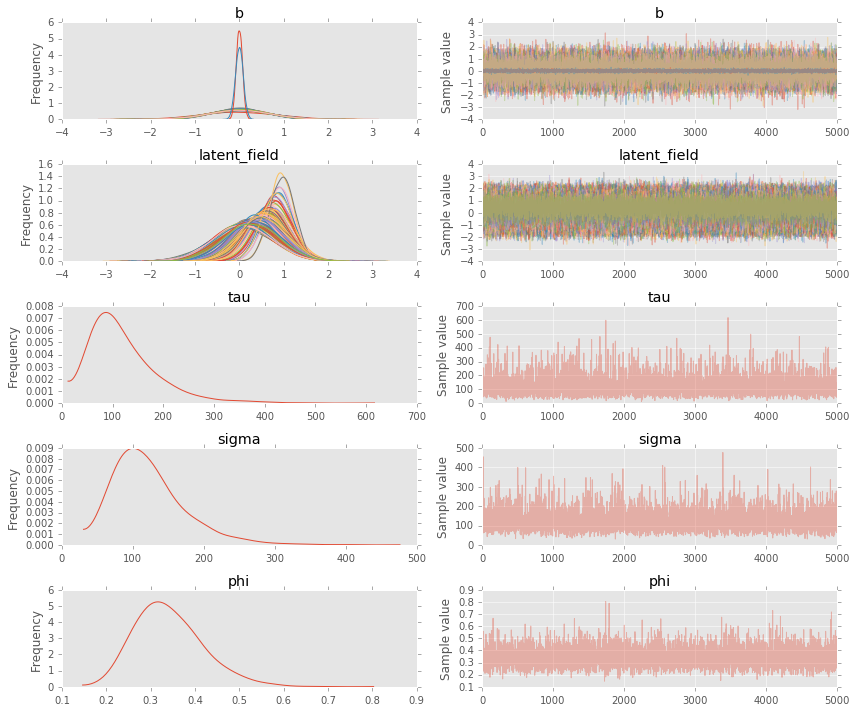

In [16]:
pm.traceplot(trace)

In [21]:
def plotThings(pred_samples):
    preds = pd.DataFrame(pred_samples['f_star']).transpose()
    import scipy.special as sp
    alpha = sp.logit(0.5)
    mean_sample = preds.mean(axis=1)
    q_025 = preds.quantile(0.025,axis=1)
    q_975 = preds.quantile(0.975,axis=1)
    prob_gt05 = preds.apply(lambda row : float(sum(row > alpha))/100,axis=1)
    surface_data = pd.DataFrame({'mean_sample' : mean_sample, 'q_025':q_025,'q_975':q_975,'prob_gt05':prob_gt05})

    #preds['idx'] = data_star.index.values
    surface_data['idx'] = datapred['clean'].index.values
    predictions = datapred['full'].merge(surface_data,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
    predicted_data = predictions.mean_sample.values
    # Raster Container
    ql_presences_of_something = RasterContainer(predictions.q_025.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
    ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu,interpolation='None',title="Quantiles 0.025")

    mean_presences_of_something = RasterContainer(predicted_data,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
    mean_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu,interpolation='None',title="mean probability")

    qh_presences_of_something = RasterContainer(predictions.q_975.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
    qh_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu,interpolation='None',title="quantile 0.097")

    ## Probability of the probaaility of presences bigger than 0.5
    prob5 = RasterContainer(predictions.prob_gt05.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
    prob5.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu,interpolation='None',title="probability of exceding more than 0.5")


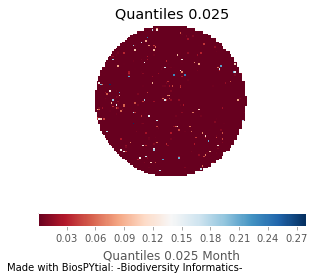

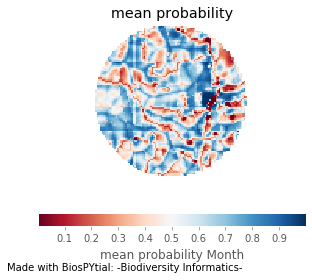

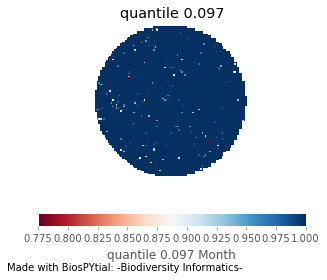

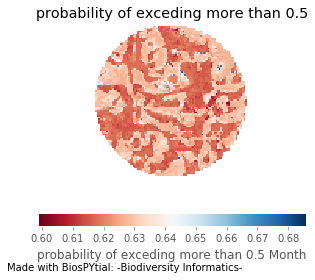

In [24]:
#from external_plugins.spystats.spystats import utilities as ut
plotThings(pred_samples)

In [29]:
import redis
conn = redis.StrictRedis(host='redis',password='biospytial.')
import pickle

In [32]:
tracedf = pm.trace_to_dataframe(trace)

In [34]:
tracedf.to_csv?

Signature: tracedf.to_csv(path_or_buf=None, sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None, compression=None, quoting=None, quotechar='"', line_terminator='\n', chunksize=None, tupleize_cols=None, date_format=None, doublequote=True, escapechar=None, decimal='.')
Docstring:
Write DataFrame to a comma-separated values (csv) file

Parameters
----------
path_or_buf : string or file handle, default None
    File path or object, if None is provided the result is returned as
    a string.
sep : character, default ','
    Field delimiter for the output file.
na_rep : string, default ''
    Missing data representation
float_format : string, default None
    Format string for floating point numbers
columns : sequence, optional
    Columns to write
header : boolean or list of string, default True
    Write out the column names. If a list of strings is given it is
    assumed to be aliases for the column names
index : boolean

In [30]:
conn.set('manual-test-advi',pickle.dumps(bundle))

MemoryError: out of memory

# MCMC

In [ ]:
ut.plotThings(pred_samples,datapred,elevation)

In [ ]:
pm.traceplot(trace)

In [ ]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
expit(ql_presences_of_something.rasterdata.bands[0].data())
plt.imshow(ql_presences_of_something.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.Greens)
plt.title("Presences quantile 0.025")
plt.colorbar(orientation='horizontal')

In [ ]:
rastertemplate=elevation
preds = pd.DataFrame(pred_samples['f_star']).transpose()
import scipy.special as sp
alpha = sp.logit(0.5)
mean_sample = preds.mean(axis=1)
q_025 = preds.quantile(0.025,axis=1)
q_975 = preds.quantile(0.975,axis=1)
prob_gt05 = preds.apply(lambda row : float(sum(row > alpha))/100,axis=1)
surface_data = pd.DataFrame({'mean_sample' : mean_sample, 'q_025':q_025,'q_975':q_975,'prob_gt05':prob_gt05})

#preds['idx'] = data_star.index.values
surface_data['idx'] = datapred['clean'].index.values
predictions = datapred['full'].merge(surface_data,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
predicted_data = predictions.mean_sample.values
# Raster Container
ql_presences_of_something = RasterContainer(predictions.q_025.values,use_metadata_from=rastertemplate.rasterdata,exponential_fam="Bernoulli")
ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu,interpolation='None',title="Quantiles 0.025")

mean_presences_of_something = RasterContainer(predicted_data,use_metadata_from=rastertemplate.rasterdata,exponential_fam="Bernoulli")
mean_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu,interpolation='None',title="mean probability")

qh_presences_of_something = RasterContainer(predictions.q_975.values,use_metadata_from=rastertemplate.rasterdata,exponential_fam="Bernoulli")
qh_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu,interpolation='None',title="quantile 0.097")

## Probability of the probaaility of presences bigger than 0.5
prob5 = RasterContainer(predictions.prob_gt05.values,use_metadata_from=rastertemplate.rasterdata,exponential_fam="Bernoulli")
prob5.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu,interpolation='None',title="probability of exceding more than 0.5")


In [ ]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(mean_presences_of_something.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.Greens,clim=(0,1))

plt.colorbar(orientation='horizontal')
plt.title('Probability of presences (mean surface)' )

In [ ]:
mean_presences_of_something.exportToGeoTiff("nuevo_mapa")

In [ ]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(qh_presences_of_something.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.Greens,clim=(0,1))
plt.colorbar(orientation='horizontal')
plt.title("Presences quantile 0.975")

In [ ]:
ut.plotThings??

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(prob5.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.RdBu,clim=(0,1))
plt.colorbar(orientation='horizontal')
plt.title("Probability of probability more than 0.5 of presence of Burseracea family")

## Export results to GEotif!

In [ ]:
name = "sample_root"
ql_presences_of_something.exportToGeoTiff("ql_"+name)


In [ ]:
mean_presences_of_something.exportToGeoTiff("mean_"+name)

In [ ]:
qh_presences_of_something.exportToGeoTiff("qh_"+name)

In [ ]:
prob5.exportToGeoTiff("prob05"+name)

In [ ]:

    with pm.Model() as model:

        # partition dataframes df
        Ydf = trainDM[0]
        TXdf = trainDM[1]

        PXdf = PredDM

        ## Parameters for linear predictor
        #b0 = pm.Normal('b0',mu=0,sd=10)
        #dum_names = filter(lambda col : str(col).startswith('inegiv5name'),TXdf)
        #dumsdf = TXdf[dum_names]
        #dumshape = dumscols.shape
        #coordsdf = TXdf[['Longitude','Latitude']]

        # Create vectors for dumi vars 
        #drvs = map(lambda col : pm.Normal(col,mu=0,sd=1.5),dum_names)
        ## Create theano vector
        dimX = len(TXdf.columns)
        b = pm.Normal('b',mu=0,sd=1.5,shape=dimX)
        #mk = pm.math.matrix_dot(TXdf.values,b.transpose())



        ## The latent function
        x_index = TXdf.columns.get_loc(b"Longitude")
        y_index = TXdf.columns.get_loc(b"Latitude")

        ## Building the covariance structure
        tau = pm.HalfNormal('tau',sd=10)
        sigma = pm.HalfNormal('sigma',sd=10)
        #phi = pm.Uniform('phi',0,15)
        phi = pm.HalfNormal('phi',sd=6)
        Tau = pm.gp.cov.Constant(tau)
        cov = (sigma * pm.gp.cov.Matern32(2,phi,active_dims=[x_index,y_index])) + Tau

        mean_f = pm.gp.mean.Linear(coeffs=b)

        gp = pm.gp.Latent(mean_func=mean_f,cov_func=cov)

        f = gp.prior("latent_field", X=TXdf.values,reparameterize=False)


        yy = pm.Bernoulli("yy",logit_p=f,observed=Ydf.values)



        trace = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
        #trace = pm.sample(150,init='adapt_diag')
        trace = trace.sample(draws=5000)

        # Remove any column that doesnt appear in the training data
        ValidPreds = PredDM[TXdf.columns]
        PredX = ValidPreds.values

        f_star = gp.conditional("f_star", PredX)

        pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=100)


